In [120]:
import matplotlib

params = {
#     'text.latex.preamble': ['\\usepackage{gensymb}'],
#     'image.origin': 'lower',
#     'image.interpolation': 'nearest',
#     'image.cmap': 'gray',
#     'axes.grid': False,
#     'savefig.dpi': 100, 
    'xtick.direction': 'in',
    'ytick.direction': 'in',
#     'axes.labelsize': 12,
#     'axes.titlesize': 12,
    'font.size': 14, 
#     'legend.fontsize': 15, 
#     'xtick.labelsize': 15,
#     'ytick.labelsize': 15,
    'text.usetex': True,
    'font.family': 'serif',
}

matplotlib.rcParams.update(params)

### Residual Plot

In [119]:
from pint.models import get_model_and_toas
import pint.fitter
import pint.derived_quantities
import pint.logging
import matplotlib.pyplot as plt

from astropy import units

WARNING  (pint.logging                  ): /opt/anaconda3/envs/psr/lib/python3.8/site-packages/pint/observatory/clock_file.py:176 UserWarning: Data points out of range in clock file 'gps2utc.clk'
WARNING  (pint.logging                  ): /opt/anaconda3/envs/psr/lib/python3.8/site-packages/pint/observatory/clock_file.py:176 UserWarning: Data points out of range in clock file 'pks2gps.clk'


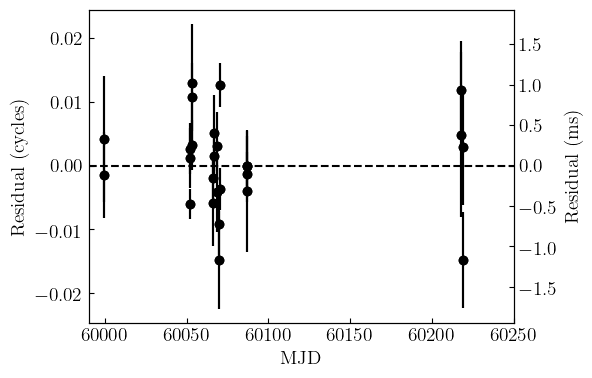

In [122]:
pint.logging.setup("WARNING")
# m, t = get_model_and_toas("../data/PSRJ1032.par", "../data/23-may.tim")
m, t = get_model_and_toas("../data/oct-3-pint.par", "../data/oct-3-pint.tim")
m.change_pepoch(60050)
f = pint.fitter.Fitter.auto(t, m)
f.fit_toas()

# plt.clf()
plt.figure(figsize=(6, 4))
plt.errorbar(
    t.get_mjds().value,
    f.resids.phase_resids.value,
    yerr=(t.get_errors() * f.model.F0.quantity).decompose().value,
    fmt="o", color="black"
)
plt.plot([59990, 60250], [0, 0], "k--")
plt.gca().set_xlim(59990, 60250)
plt.xlabel("MJD") #, fontsize=fontsize)
plt.ylabel("Residual (cycles)") #, fontsize=fontsize)
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.errorbar(
    t.get_mjds().value,
    f.resids.time_resids.to_value(units.ms),
    yerr=(t.get_errors().to_value(units.ms)),
    fmt="o", color="black"
)
ax2.set_ylabel("Residual (ms)") #, fontsize=fontsize)
ax2.tick_params(axis="y") #, labelsize=fontsize)

plt.gcf().tight_layout()
P, Pdot = pint.derived_quantities.p_to_f(f.model.F0.quantity, f.model.F1.quantity)
plt.savefig("../figures/PSRJ1032_residuals.pdf", bbox_inches="tight")


### Scattering - Frequency

In [20]:
import numpy as np
from scipy.signal import savgol_filter, convolve
import scipy.optimize
from astropy import units as u, constants as c
import matplotlib.pyplot as plt


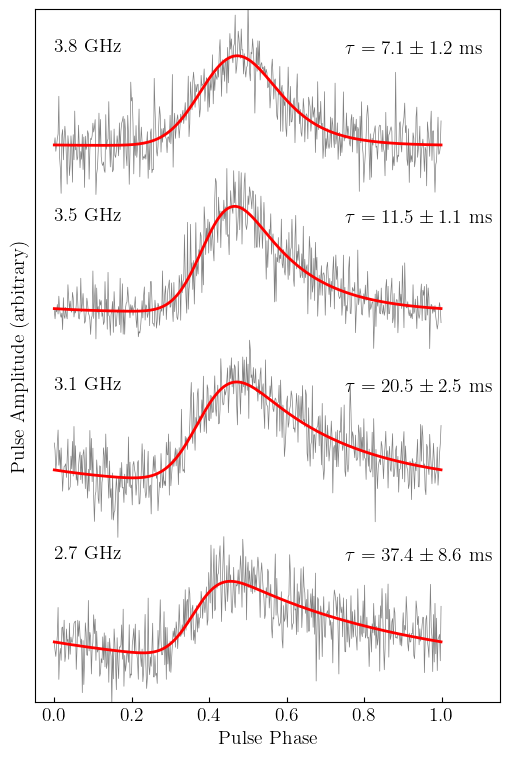

In [92]:
def pulse(x, A, mu, sigma, y0):
    return A * np.exp(-((x - mu) ** 2) / 2 / sigma**2) + y0


def convolved_pulse(x, A, mu, sigma, y0, tau):
    y = pulse(x, A, mu, sigma, y0)
    xx = np.r_[x, x + 1]
    yy = np.r_[y, y]
    kernel = np.exp(-xx / tau) * (xx < 1)
    out = convolve(yy, kernel, mode="same")
    return out[xx < 1] / kernel.sum()


def powerlaw(f, A, alpha):
    return A * f**alpha


if False:
    import pypulse

    # module add psrchive/2
    # psrconv -o PSRFITS added_gt_2_5GHz.ar
    ar = pypulse.Archive("J1032-5804/added_gt_2_5GHz.rf")
    ar.tscrunch()
    data = ar.getData()
    data = data / 4e-6
    f = ar.freq[0] * u.MHz
    P = ar.getPeriod() * u.s
    np.savez("profile.npz", data=data, f=f, P=P)
else:
    arz = np.load("../data/profile.npz")
    data = arz["data"]
    f = arz["f"] * u.MHz
    P = arz["P"] * u.s
n = 4
profiles = np.zeros((n, data.shape[1]))
d0 = np.nanmedian(data, axis=0)
x = np.arange(data.shape[1]) / data.shape[1]
ff = np.zeros(n) * u.MHz
tau = np.zeros(n) * u.ms
tau_err = np.zeros(n) * u.ms

plt.figure(figsize=(6, 9))

for i in range(n):
    chanstart = (len(f) // n) * i
    chanstop = (len(f) // n) * (i + 1)
    goodchan = (~np.isnan(data[chanstart:chanstop, 0])).sum()
    d = np.nanmedian(data[chanstart:chanstop], axis=0)
    filt = savgol_filter(np.r_[d, d, d], 151, 3)
    dfilt = filt[len(d) : 2 * len(d)]
    snr = (np.mean(dfilt) / (d - dfilt).std()) * np.sqrt((len(f) // n) / goodchan)
    popt, pcov = scipy.optimize.curve_fit(
        convolved_pulse,
        x,
        d,
        p0=[10, 0.35, 0.1, -0.2, 0.5],
        sigma=(d - dfilt).std() * np.ones(len(x)),
        absolute_sigma=True,
    )
    perr = np.sqrt(np.diag(pcov))
    tau[i] = popt[-1] * P
    tau_err[i] = perr[-1] * P
    plt.plot(
        x, 0.55 * d  + n - i - 1, #+ f[chanstart:chanstop].mean().to(u.GHz).value,
        label=f"{f[chanstart:chanstop].mean().to(u.GHz):.1f} ($\\tau={tau[i].to_value(u.ms):.1f}\\pm{tau_err[i].to_value(u.ms):.1f}$ ms)",
        lw=0.5, color="gray"
    )
    ff[i] = f[chanstart:chanstop].mean()

#     plt.plot(x, dfilt , "k-")
    plt.plot(
        x, 0.55 * convolved_pulse(x, *popt) + n - i - 1, 
        "r", lw=2
    )
    
    plt.text(
        0.0, 0.55 + n - i - 1, 
        f"{f[chanstart:chanstop].mean().to(u.GHz):.1f}",
        ha="left", 
    )
    
    plt.text(
        0.75, 0.55 + n - i - 1, 
        f"$\\tau={tau[i].to_value(u.ms):.1f}\\pm{tau_err[i].to_value(u.ms):.1f}$ ms",
        ha="left", 
    )

# plt.legend()
plt.xlabel("Pulse Phase") #, fontsize=14)
plt.ylabel("Pulse Amplitude (arbitrary)") #, fontsize=14)
plt.xlim(-0.05, 1.15)
plt.ylim(-0.3, 3.8)

plt.yticks([])
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.savefig("../figures/PSRJ1032_profiles_scattering.pdf", bbox_inches="tight")




### DM-scattering Relation

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

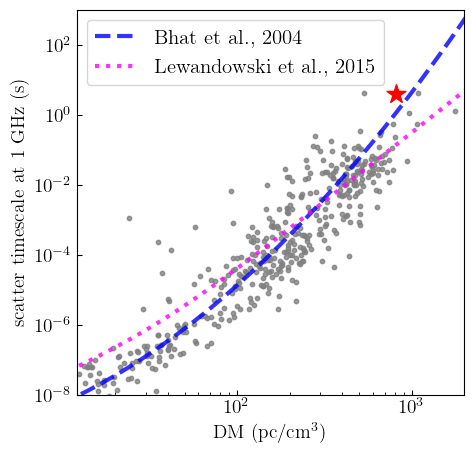

In [101]:
taudf = pd.read_csv("../data/psrcat_scatter.csv")

tauarr = taudf["TAU_SC"].to_numpy()
tauarr = tauarr[~np.isnan(tauarr)]
tauarr.sort()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

xx = np.linspace(2, 3000, 1000)
### plot Bhat DM-tau relation - https://arxiv.org/pdf/astro-ph/0401067.pdf
yy1 = 10**(-6.46 + 0.154 * np.log10(xx) + 1.07 * np.log10(xx) ** 2) * 1e-3 # this is at 1 GHz, in ms
### plot another DM-tau relation - https://arxiv.org/pdf/1502.06330.pdf
yy2 = 2.26e-7 * xx ** 2.2 * (1 + 0.00205 * xx**1.74) * 1e-3


ax.scatter(taudf["DM"], taudf["TAU_SC"], color="gray", s=10, alpha=0.8)
ax.scatter(819, 3.845, marker="*", s=200, color="red")

ax.plot(xx, yy1, color="blue", ls="--", lw=3, alpha=0.8, label="Bhat et al., 2004")
ax.plot(xx, yy2, color="magenta", ls=":", lw=3, alpha=0.8, label="Lewandowski et al., 2015")
ax.set_xlim(12, 2000)
ax.set_ylim(1e-8, 1e3)
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(fontsize=15)

ax.set_xlabel(r"DM (pc/cm$^{3}$)")
ax.set_ylabel(r"scatter timescale at 1 GHz (s)")

fig.savefig("../figures/PSRJ1032_tauDM.pdf", bbox_inches="tight")

### DM-RM relation

In [104]:
import numpy as np
from astropy import units as u, constants as c
from astropy.table import Table
from astropy.coordinates import SkyCoord
from matplotlib import pyplot as plt


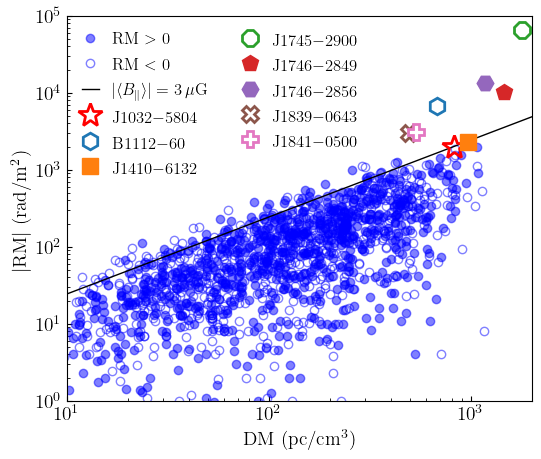

In [131]:
t = Table.read("../data/dm_rm.csv", format="ascii.csv", delimiter=";")
DM = 819
RM = -2000
pos = SkyCoord("10:32:50.44900000", "-58:04:34.57900000", unit=("hour", "deg"))
poss = SkyCoord(t["RAJD"] * u.deg, t["DECJD"] * u.deg)

dm = np.logspace(0, 3.5)

neg = t["RM"] < 0
close = pos.separation(poss) < 5 * u.deg

fig = plt.figure(figsize=(6, 5))

plt.loglog(
    t[~neg]["DM"],
    t[~neg]["RM"],
    "bo",
    markersize=6,
    label=r"RM $>$ 0",
    alpha=0.5,
)
plt.loglog(
    t[neg]["DM"],
    -t[neg]["RM"],
    "bo",
    markerfacecolor="none",
    markersize=6,
    label=r"RM $<$ 0",
    alpha=0.5,
)

plt.loglog(
    dm,
    (3 / 1.23) * dm,
    "k",
    linewidth=1,
    label="$|\langle B_{\parallel}\\rangle|=3\,\mu$G",
)
plt.plot(
    DM,
    -RM,
    "r*",
    markersize=18,
    markeredgewidth=2,
    markerfacecolor="none",
    label="J1032$-$5804",
)
sources = {
    "B1112-60": "h",
    "J1410-6132": "s",
    "J1745-2900": "8",
    "J1746-2849": "p",
    "J1746-2856": "H",
    "J1839-0643": "X",
    "J1841-0500": "P",
}
for source in sources:
    x = t[t["NAME"] == source]["DM"]
    y = t[t["NAME"] == source]["RM"]
    if y > 0:
        plt.loglog(
            x[0],
            np.abs(y)[0],
            marker=sources[source],
            label=source.replace("-", "$-$"),
            linestyle="none",
            markersize=12,
        )
    else:
        plt.loglog(
            x[0],
            np.abs(y)[0],
            marker=sources[source],
            markerfacecolor="w",
            markeredgewidth=2,
            label=source.replace("-", "$-$"),
            linestyle="none",
            markersize=12,
        )


plt.gca().set_xlim(10, 2000)
plt.gca().set_ylim(1, 1e5)
plt.xlabel("DM (pc/cm$^3$)", fontsize=14)
plt.ylabel(r"$|$RM$|$ (rad/m$^2$)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(
    loc=2, ncol=2, fontsize=12,
    facecolor="none", edgecolor="none",
    handlelength=1.
)
# plt.gcf().tight_layout()
plt.savefig("../figures/PSRJ1032_DM_RM.pdf", bbox_inches="tight")


### Polarimetry

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.ndimage
import psrchive
from copy import copy, deepcopy
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, FormatStrFormatter, AutoMinorLocator
import matplotlib.ticker as ticker
import matplotlib as mpl
import math
import numpy.ma as ma
import matplotlib.colors as colors
import sys

In [21]:
# Loading the Archive and Preprocessing
arch = psrchive.Archive_load("../data/uwl_230502_063641_added.208nchn_64subint_512nbin.clfd.calib.gt_2.with_rmfit")
stokes_arch = arch.clone()
stokes_arch.convert_state("Stokes")
stokes_arch.remove_baseline()
stokes_arch.fscrunch()
stokes_arch.tscrunch_to_nsub(1)
# stokes_arch.get_state()

# Extracting Profile Data

data = stokes_arch.get_data()
data = stokes_arch.get_data().squeeze()
Nx = 512
phase = np.linspace(0, Nx, Nx) / Nx
summed_data = np.sum(data, axis=0)

max_y = np.max(summed_data)
pulse_phase = phase[np.where(summed_data == max_y)]
rotate_phase = 1 - (0.5 + pulse_phase)
rotate_phase = np.float(rotate_phase)
stokes_arch.rotate_phase(-rotate_phase)

data = stokes_arch.get_data().squeeze()

# Extracting Statistics
subint = stokes_arch.get_Integration(0)
stats = subint.baseline_stats()
mean = stats[0]
var = stats[1]
I_std = np.sqrt(var[0])
Q_std = np.sqrt(var[1])
U_std = np.sqrt(var[2])
V_std = np.sqrt(var[3])

# Extracting I, Q, U, V components
I = data[0]
Q = data[1]
U = data[2]
V = data[3]

# Polarization Calculations
linear_pol = np.sqrt(Q**2. + U**2.)
linear_pol_mean = np.mean(linear_pol)
linear_pol = linear_pol - linear_pol_mean
circ_pol = V
P_A = np.degrees(np.arctan(U/Q))
P_A_error = np.degrees((Q**2 * U_std**2 + U**2 * Q_std**2) / (4 * (Q**2 + U**2)))


pa = []
phi = []
pa_err = []
# print(phase, P_A)
for ii, jj, kk in zip(phase, P_A, P_A_error):
    pa.append(jj)
    phi.append(ii)
    pa_err.append(kk)
pa = np.array(pa, dtype=float)
phi = np.array(phi, dtype=float)
pa_err = np.array(pa_err, dtype=float)

/var/folders/v0/by4rcdr95zv_0_lfbsl7z6kr0000gn/T/ipykernel_65953/3199839899.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rotate_phase = np.float(rotate_phase)


In [59]:
### dynamic spectra data
ds_arch = arch.clone()

#arch = psrchive.Archive_load("uwl_230502_063641_added.208nchn_64subint_512nbin.clfd.calib.gt_2.with_rmfit")

ds_arch.centre_max_bin()
ds_arch.dedisperse()
ds_arch.tscrunch()
#stokes_arch.pscrunch()
ds_arch.fscrunch_to_nchan(96)
ds_arch.remove_baseline()
real_data = ds_arch.get_data().squeeze()
real_data[real_data == 0.] = np.nan

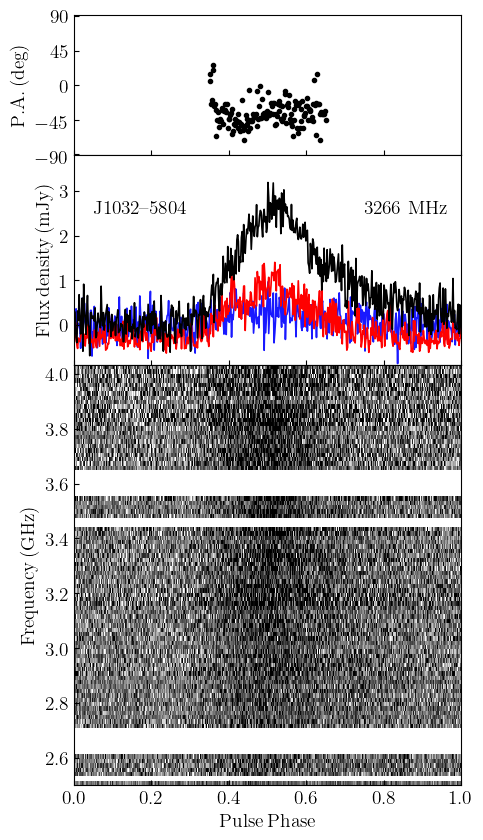

In [85]:
fig = plt.figure(figsize=(5, 10))
gs = gridspec.GridSpec(3, 1, height_ratios=[2,3, 6], hspace=0.)

ax0 = plt.subplot(gs[0])
### only plot the region with detection
paplotbool = (phi > 0.35) & (phi < 0.65)
ax0.errorbar(
    phi[paplotbool], pa[paplotbool], yerr=pa_err[paplotbool],
    color="black", marker="o", ls="", markersize=3
    
)
ax0.set_ylim(-91, 91)
ax0.set_yticks([-90, -45, 0, 45, 90])
ax0.set_ylabel(r"$\rm P.A. \, (deg)$",)

plt.setp(ax0.get_xticklabels(), visible=False)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.plot(phase, I,'k-', linewidth=1.2, zorder=2 )
ax1.plot(phase, linear_pol, color='red', linestyle='-', linewidth=1.2, zorder=1)
ax1.plot(phase, circ_pol, color='blue', linestyle='-', linewidth=1.2, alpha=0.9,zorder=0 )

ax1.set_ylabel(r'$\rm Flux \,  density\, (mJy)$', )
ax1.xaxis.label.set_visible(False)
ax1.text(0.75, 2.5, "3266 MHz", )
ax1.text(0.05, 2.5, r"J1032--5804", )
ax1.set_ylim(-0.9, 3.8)

plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(gs[2], sharex = ax0)
ax2.imshow(
    real_data[0], extent=[0.0, 1.0, 2.5, 4.032], 
    aspect="auto", cmap="gray_r", origin="lower", 
    interpolation="none", vmin=-3.5, vmax=3.
)


ax2.set_xlabel(r'$\rm Pulse \, Phase$')
ax2.set_ylabel(r'$\rm Frequency \, (GHz)$', )

fig.savefig("../figures/PSRJ1032-polarimetry.pdf", bbox_inches="tight")


### Extended Emission Figure

In [ ]:
import numpy as np
from astropy import units as u, constants as c
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.nddata
from reproject import reproject_interp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import gridspec

In [91]:
fEMU = fits.open("../data/psrj1032_EMU_cutout.fits")
fWISE = fits.open("../data/WISE_skyview_cutout.fits")
fVPHAS = fits.open("../data/vphas.fits")

wcs = WCS(fEMU[0].header)
wcs2 = WCS(fWISE[0].header)
wcs3 = WCS(fVPHAS[0].header)

emu_array = fEMU[0].data
wise_array, footprint = reproject_interp(fWISE[0], fEMU[0].header)
vphas_array, footprint = reproject_interp(fVPHAS[0], fEMU[0].header)

Set OBSGEO-B to   -26.704100 from OBSGEO-[XYZ].
Set OBSGEO-H to      121.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [108]:
def brighten(arr, alpha=0.13, beta=0):
    return np.clip(alpha*arr + beta, 0, 255)

def gammacorr(arr, gamma=2):
    return np.power(arr, 1/gamma)

def normalise(arr, arr_min=None, arr_max=None):
    arr = arr.copy()
    
    if arr_min is None: arr_min = arr.min()
    if arr_max is None: arr_max = arr.max()
    
    arr[arr < arr_min] = arr_min
    arr[arr > arr_max] = arr_max
    
    return (arr-arr_min) / (arr_max - arr_min)

Normal Plot

<IPython.core.display.Javascript object>


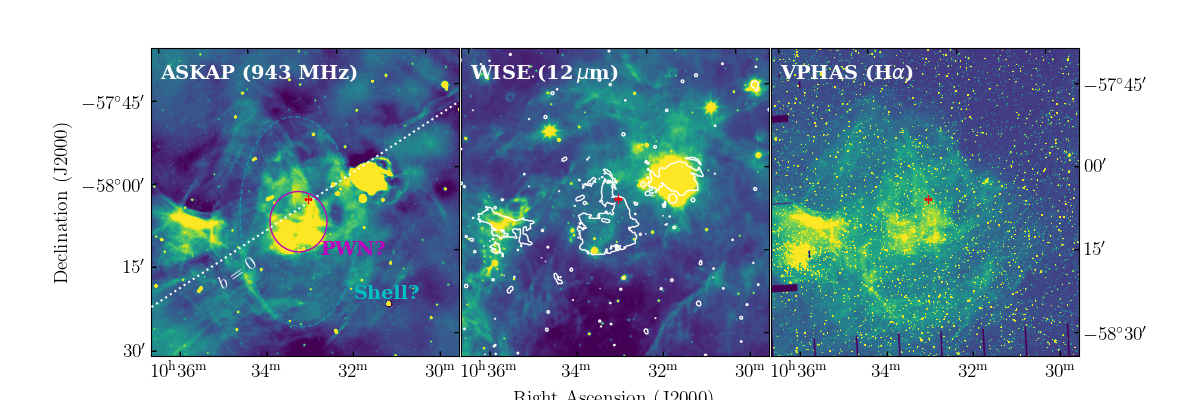

In [151]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, wspace=0.)


############################################
### EMU
############################################
ax = plt.subplot(gs[0], projection=wcs)

# ax = fig.add_subplot(1, 3, 1, projection=wcs)

ax.imshow(
    fEMU[0].data, vmin=-0.000655962, vmax=0.00147652, origin="lower",
)

# ax.coords.grid(True, color="white", ls="solid")
ax.coords[0].set_axislabel(" ", )
ax.coords[1].set_axislabel("Declination (J2000)", )


gline = SkyCoord(
    np.array([284, 286.5]) * u.deg, np.array([0, 0]) * u.deg, frame="galactic"
)
ax.plot(gline.fk5.ra, gline.fk5.dec, "w:", transform=ax.get_transform("fk5"))
gline_w = wcs.world_to_pixel(gline.fk5)
dgline = gline_w[1] - gline_w[0]
ax.text(
    400, 410, "$b=0$", rotation=np.degrees(np.arctan2(dgline[1], -dgline[0])), color="w"
)
# ax.set_xlim(350, 1520)
# ax.set_ylim(110, 1440)
ax.set_xlim(50, 1720)
ax.set_ylim(50, 1720)
ax.text(100, 1550, "ASKAP (943 MHz)", color="w", fontweight='bold', usetex=False)
ax.plot(source.ra, source.dec, "r+", transform=ax.get_transform("fk5"))

ell = Ellipse(
    (158.2698745, -58.1420344),
    2 * 0.175 / np.cos(np.radians(-58.1420344)),
    2 * 0.317,
    edgecolor="c",
    alpha=0.5,
    linestyle="--", 
    facecolor="none",
    transform=ax.get_transform("fk5"),
)
ax.add_patch(ell)
ax.text(
    157.981,
    -58.384,
    "Shell?",
    color="c",
    fontweight='bold', usetex=False,
    transform=ax.get_transform("fk5"),
)
ell2 = Ellipse(
    (158.2698745, -58.1420344),
    2 * 0.086 / np.cos(np.radians(-58.1420344)),
    2 * 0.091,
    edgecolor="m",
    facecolor="none",
    transform=ax.get_transform("fk5"),
)
ax.add_patch(ell2)
ax.text(
    158.160,
    -58.247,
    "PWN?",
    color="m",
    fontweight='bold', usetex=False,
    transform=ax.get_transform("fk5"),
)

############################################
### WISE
############################################

ax2 = plt.subplot(gs[1], projection=wcs)
# ax2 = fig.add_subplot(1, 3, 2, projection=wcs)
wise_array[np.isnan(wise_array)] = 10000
ax2.imshow(wise_array, vmin=394, vmax=909, origin="lower")
ax2.text(100, 1550, "WISE (12$\,\mu$m)", color="w", fontweight='bold', usetex=False)

# ax.coords.grid(True, color="white", ls="solid")
ax2.coords[0].set_axislabel("Right Ascension (J2000)", )
ax2.coords[1].set_axislabel(" ")

ax2.set_xlim(50, 1720)
ax2.set_ylim(50, 1720)
# ax2.coords[1].tick_right()
ax2.coords[1].set_axislabel_position("right")
ax2.coords[1].set_ticklabel_position("right")
ax2.coords[1].set_ticks_position("right")
ax2.plot(source.ra, source.dec, "r+", transform=ax2.get_transform("fk5"))

ax2.contour(
    fEMU[0].data,
    transform=ax2.get_transform(wcs),
    levels=[
        1e-3,
    ],
    colors="white",
    linewidths=1,
)

############################################
### VPHAS
############################################

ax3 = plt.subplot(gs[2], projection=wcs)
# ax3 = fig.add_subplot(1, 3, 3, projection=wcs)
ax3.imshow(vphas_array, vmin=0, vmax=120, origin="lower")
ax3.text(100, 1550, "VPHAS (H$\\alpha$)", color="w", fontweight='bold', usetex=False)

# ax.coords.grid(True, color="white", ls="solid")
ax3.coords[0].set_axislabel(" ")
ax3.coords[1].set_axislabel(" ")
ax3.set_xlim(50, 1720)
ax3.set_ylim(50, 1720)
# ax2.coords[1].tick_right()
ax3.coords[1].set_axislabel_position("right")
ax3.coords[1].set_ticklabel_position("right")
ax3.coords[1].set_ticks_position("right")
ax3.plot(source.ra, source.dec, "r+", transform=ax3.get_transform("fk5"))

# emu_narr = normalise(emu_array, arr_min=-0.0007, arr_max=0.002)
# wise_narr = normalise(wise_array, arr_min=500, arr_max=1200)
# wise_narr[np.isnan(wise_narr)] = np.nanmax(wise_narr)
# vphas_narr = normalise(vphas_array, arr_min=10, arr_max=150)

# rgb_composite = np.dstack((emu_narr, vphas_narr, wise_narr, ))

# ax4 = plt.subplot(gs[3], projection=wcs)
# ax4.imshow(rgb_composite, origin="lower")

# ax4.coords[0].set_axislabel(" ", )
# ax4.coords[1].set_axislabel(" ")

# ax4.coords[1].set_axislabel_position("right")
# ax4.coords[1].set_ticklabel_position("right")
# ax4.coords[1].set_ticks_position("right")

# plt.show()
# fig.tight_layout()
# plt.subplots_adjust(wspace=0)
# fig.savefig("PSRJ1032_EMU_WISE_VPHAS.pdf", bbox_inches="tight")


With a different colormap

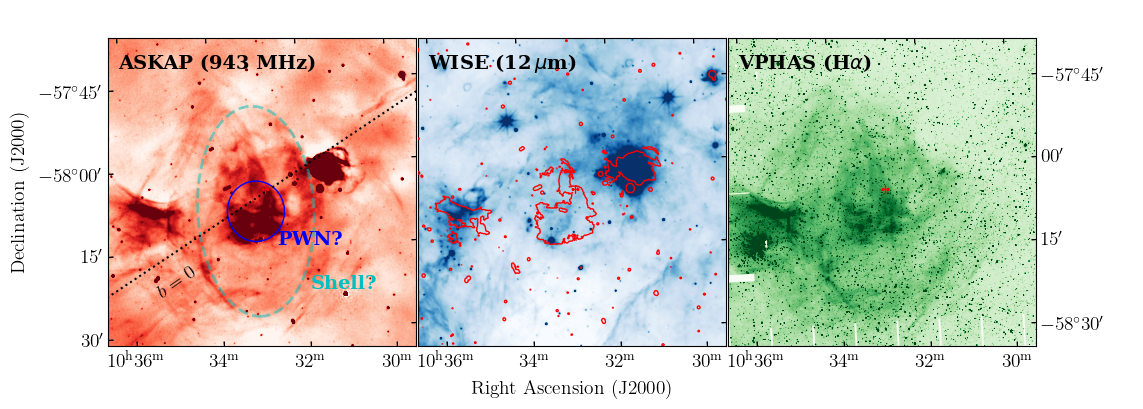

In [176]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, wspace=0.)


############################################
### EMU
############################################
ax = plt.subplot(gs[0], projection=wcs)

# ax = fig.add_subplot(1, 3, 1, projection=wcs)

ax.imshow(
    fEMU[0].data, vmin=-0.000655962, vmax=0.00147652, origin="lower",
    cmap="Reds"
)

# ax.coords.grid(True, color="white", ls="solid")
ax.coords[0].set_axislabel(" ", )
ax.coords[1].set_axislabel("Declination (J2000)", )


gline = SkyCoord(
    np.array([284, 286.5]) * u.deg, np.array([0, 0]) * u.deg, frame="galactic"
)
ax.plot(gline.fk5.ra, gline.fk5.dec, "k:", transform=ax.get_transform("fk5"))
gline_w = wcs.world_to_pixel(gline.fk5)
dgline = gline_w[1] - gline_w[0]
ax.text(
    300, 310, "$b=0$", rotation=np.degrees(np.arctan2(dgline[1], -dgline[0])), color="k"
)
# ax.set_xlim(350, 1520)
# ax.set_ylim(110, 1440)
ax.set_xlim(50, 1720)
ax.set_ylim(50, 1720)
ax.text(100, 1550, "ASKAP (943 MHz)", color="k", fontweight='bold', usetex=False)
ax.plot(source.ra, source.dec, "r+", transform=ax.get_transform("fk5"))

ell = Ellipse(
    (158.2698745, -58.1420344),
    2 * 0.175 / np.cos(np.radians(-58.1420344)),
    2 * 0.317,
    edgecolor="c",
    alpha=0.5,
    linestyle="--", lw=2,
    facecolor="none",
    transform=ax.get_transform("fk5"),
)
ax.add_patch(ell)
ax.text(
    157.981,
    -58.384,
    "Shell?",
    color="c",
    fontweight='bold', usetex=False,
    transform=ax.get_transform("fk5"),
)
ell2 = Ellipse(
    (158.2698745, -58.1420344),
    2 * 0.086 / np.cos(np.radians(-58.1420344)),
    2 * 0.091,
    edgecolor="b",
    facecolor="none",
    transform=ax.get_transform("fk5"),
)
ax.add_patch(ell2)
ax.text(
    158.160,
    -58.247,
    "PWN?",
    color="b",
    fontweight='bold', usetex=False,
    transform=ax.get_transform("fk5"),
)

############################################
### WISE
############################################

ax2 = plt.subplot(gs[1], projection=wcs)
# ax2 = fig.add_subplot(1, 3, 2, projection=wcs)
wise_array[np.isnan(wise_array)] = 10000
ax2.imshow(wise_array, vmin=394, vmax=909, origin="lower", cmap="Blues")
ax2.text(100, 1550, "WISE (12$\,\mu$m)", color="k", fontweight='bold', usetex=False)

# ax.coords.grid(True, color="white", ls="solid")
ax2.coords[0].set_axislabel("Right Ascension (J2000)", )
ax2.coords[1].set_axislabel(" ")

ax2.set_xlim(50, 1720)
ax2.set_ylim(50, 1720)
# ax2.coords[1].tick_right()
ax2.coords[1].set_axislabel_position("right")
ax2.coords[1].set_ticklabel_position("right")
ax2.coords[1].set_ticks_position("right")
ax2.plot(source.ra, source.dec, "r+", transform=ax2.get_transform("fk5"))

ax2.contour(
    fEMU[0].data,
    transform=ax2.get_transform(wcs),
    levels=[
        1e-3,
    ],
    colors="r",
    linewidths=1,
)

############################################
### VPHAS
############################################

ax3 = plt.subplot(gs[2], projection=wcs)
# ax3 = fig.add_subplot(1, 3, 3, projection=wcs)
ax3.imshow(vphas_array, vmin=0, vmax=120, origin="lower", cmap="Greens")
ax3.text(100, 1550, "VPHAS (H$\\alpha$)", color="k", fontweight='bold', usetex=False)

# ax.coords.grid(True, color="white", ls="solid")
ax3.coords[0].set_axislabel(" ")
ax3.coords[1].set_axislabel(" ")
ax3.set_xlim(50, 1720)
ax3.set_ylim(50, 1720)
# ax2.coords[1].tick_right()
ax3.coords[1].set_axislabel_position("right")
ax3.coords[1].set_ticklabel_position("right")
ax3.coords[1].set_ticks_position("right")
ax3.plot(source.ra, source.dec, "r+", transform=ax3.get_transform("fk5"))

# emu_narr = normalise(emu_array, arr_min=-0.0007, arr_max=0.002)
# wise_narr = normalise(wise_array, arr_min=500, arr_max=1200)
# wise_narr[np.isnan(wise_narr)] = np.nanmax(wise_narr)
# vphas_narr = normalise(vphas_array, arr_min=10, arr_max=150)

# rgb_composite = np.dstack((emu_narr, vphas_narr, wise_narr, ))

# ax4 = plt.subplot(gs[3], projection=wcs)
# ax4.imshow(rgb_composite, origin="lower")

# ax4.coords[0].set_axislabel(" ", )
# ax4.coords[1].set_axislabel(" ")

# ax4.coords[1].set_axislabel_position("right")
# ax4.coords[1].set_ticklabel_position("right")
# ax4.coords[1].set_ticks_position("right")

# plt.show()
# fig.tight_layout()
# plt.subplots_adjust(wspace=0)
# fig.savefig("PSRJ1032_EMU_WISE_VPHAS.pdf", bbox_inches="tight")


Plot along with composite image

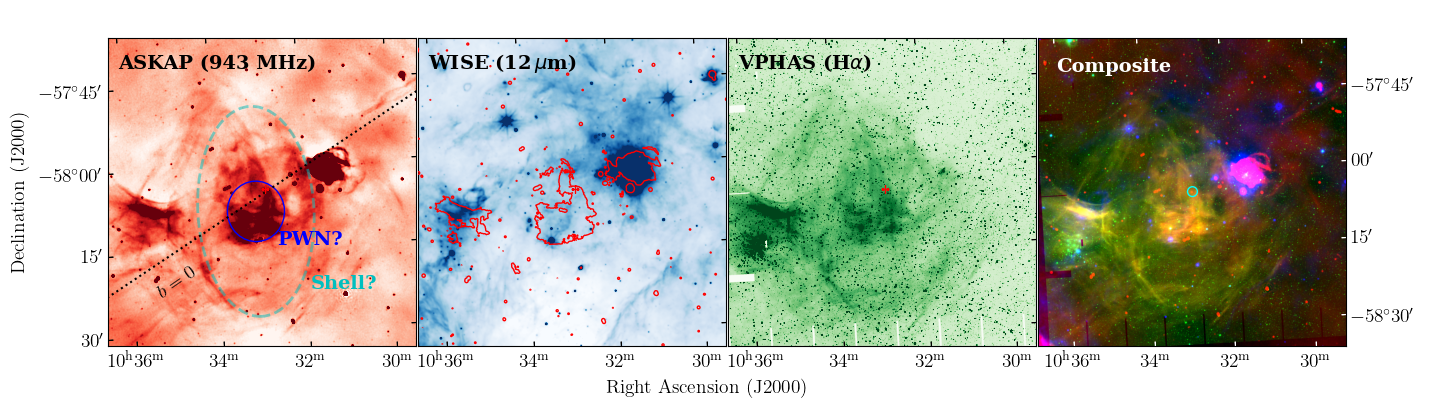

In [183]:
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, wspace=0.)


############################################
### EMU
############################################
ax = plt.subplot(gs[0], projection=wcs)

# ax = fig.add_subplot(1, 3, 1, projection=wcs)

ax.imshow(
    fEMU[0].data, vmin=-0.000655962, vmax=0.00147652, origin="lower",
    cmap="Reds"
)

# ax.coords.grid(True, color="white", ls="solid")
ax.coords[0].set_axislabel(" ", )
ax.coords[1].set_axislabel("Declination (J2000)", )


gline = SkyCoord(
    np.array([284, 286.5]) * u.deg, np.array([0, 0]) * u.deg, frame="galactic"
)
ax.plot(gline.fk5.ra, gline.fk5.dec, "k:", transform=ax.get_transform("fk5"))
gline_w = wcs.world_to_pixel(gline.fk5)
dgline = gline_w[1] - gline_w[0]
ax.text(
    300, 310, "$b=0$", rotation=np.degrees(np.arctan2(dgline[1], -dgline[0])), color="k"
)
# ax.set_xlim(350, 1520)
# ax.set_ylim(110, 1440)
ax.set_xlim(50, 1720)
ax.set_ylim(50, 1720)
ax.text(100, 1550, "ASKAP (943 MHz)", color="k", fontweight='bold', usetex=False)
ax.plot(source.ra, source.dec, "r+", transform=ax.get_transform("fk5"))

ell = Ellipse(
    (158.2698745, -58.1420344),
    2 * 0.175 / np.cos(np.radians(-58.1420344)),
    2 * 0.317,
    edgecolor="c",
    alpha=0.5,
    linestyle="--", lw=2,
    facecolor="none",
    transform=ax.get_transform("fk5"),
)
ax.add_patch(ell)
ax.text(
    157.981,
    -58.384,
    "Shell?",
    color="c",
    fontweight='bold', usetex=False,
    transform=ax.get_transform("fk5"),
)
ell2 = Ellipse(
    (158.2698745, -58.1420344),
    2 * 0.086 / np.cos(np.radians(-58.1420344)),
    2 * 0.091,
    edgecolor="b",
    facecolor="none",
    transform=ax.get_transform("fk5"),
)
ax.add_patch(ell2)
ax.text(
    158.160,
    -58.247,
    "PWN?",
    color="b",
    fontweight='bold', usetex=False,
    transform=ax.get_transform("fk5"),
)

############################################
### WISE
############################################

ax2 = plt.subplot(gs[1], projection=wcs)
# ax2 = fig.add_subplot(1, 3, 2, projection=wcs)
wise_array[np.isnan(wise_array)] = 10000
ax2.imshow(wise_array, vmin=394, vmax=909, origin="lower", cmap="Blues")
ax2.text(100, 1550, "WISE (12$\,\mu$m)", color="k", fontweight='bold', usetex=False)

# ax.coords.grid(True, color="white", ls="solid")
ax2.coords[0].set_axislabel(" ", )
ax2.coords[1].set_axislabel(" ")

ax2.set_xlim(50, 1720)
ax2.set_ylim(50, 1720)
# ax2.coords[1].tick_right()
ax2.coords[1].set_axislabel_position("right")
ax2.coords[1].set_ticklabel_position("right")
ax2.coords[1].set_ticks_position("right")
ax2.plot(source.ra, source.dec, "r+", transform=ax2.get_transform("fk5"))

ax2.contour(
    fEMU[0].data,
    transform=ax2.get_transform(wcs),
    levels=[
        1e-3,
    ],
    colors="r",
    linewidths=1,
)

############################################
### VPHAS
############################################

ax3 = plt.subplot(gs[2], projection=wcs)
# ax3 = fig.add_subplot(1, 3, 3, projection=wcs)
ax3.imshow(vphas_array, vmin=0, vmax=120, origin="lower", cmap="Greens")
ax3.text(100, 1550, "VPHAS (H$\\alpha$)", color="k", fontweight='bold', usetex=False)

# ax.coords.grid(True, color="white", ls="solid")
ax3.coords[0].set_axislabel(" ")
ax3.coords[1].set_axislabel(" ")
ax3.set_xlim(50, 1720)
ax3.set_ylim(50, 1720)
# ax2.coords[1].tick_right()
ax3.coords[1].set_axislabel_position("right")
ax3.coords[1].set_ticklabel_position("right")
ax3.coords[1].set_ticks_position("right")
ax3.plot(source.ra, source.dec, "r+", transform=ax3.get_transform("fk5"))

emu_narr = normalise(emu_array, arr_min=-0.0007, arr_max=0.002)
wise_narr = normalise(wise_array, arr_min=500, arr_max=1200)
wise_narr[np.isnan(wise_narr)] = np.nanmax(wise_narr)
vphas_narr = normalise(vphas_array, arr_min=10, arr_max=150)

rgb_composite = np.dstack((emu_narr, vphas_narr, wise_narr, ))

ax4 = plt.subplot(gs[3], projection=wcs)
ax4.imshow(rgb_composite, origin="lower")

ax4.scatter(
    source.ra, source.dec, 
    marker="o", facecolor="none", edgecolor="cyan", s=50,
    transform=ax4.get_transform("fk5")
)

ax4.coords[0].set_axislabel(" ", )
ax4.coords[1].set_axislabel(" ")

ax4.coords[1].set_axislabel_position("right")
ax4.coords[1].set_ticklabel_position("right")
ax4.coords[1].set_ticks_position("right")

ax4.coords[0].set_ticks(color="white")
ax4.coords[1].set_ticks(color="white")

ax4.text(100, 1600, "Composite", color="w", fontweight='bold', usetex=False)

plt.text(0.5, -0.02, "Right Ascension (J2000)", va="bottom", ha="center", transform=fig.transFigure)

# plt.show()
# fig.tight_layout()
# plt.subplots_adjust(wspace=0)
fig.savefig("../figures/PSRJ1032_EMU_WISE_VPHAS.pdf", bbox_inches="tight")


### Composite RGB figure

In [14]:
import numpy as np
from astropy import units as u, constants as c
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.nddata
from reproject import reproject_interp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from aplpy import make_rgb_cube, make_rgb_image
from astropy.visualization import ImageNormalize, ZScaleInterval
from matplotlib import gridspec
# from astropy.io import fits

In [3]:
fEMU = fits.open("../data/psrj1032_EMU_cutout.fits")
fWISE = fits.open("../data/WISE_skyview_cutout.fits")
fVPHAS = fits.open("../data/vphas.fits")

wcs = WCS(fEMU[0].header)
wcs2 = WCS(fWISE[0].header)
wcs3 = WCS(fVPHAS[0].header)

emu_array = fEMU[0].data
wise_array, footprint = reproject_interp(fWISE[0], fEMU[0].header)
vphas_array, footprint = reproject_interp(fVPHAS[0], fEMU[0].header)

Set OBSGEO-B to   -26.704100 from OBSGEO-[XYZ].
Set OBSGEO-H to      121.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [11]:
def brighten(arr, alpha=0.13, beta=0):
    return np.clip(alpha*arr + beta, 0, 255)

def gammacorr(arr, gamma=2):
    return np.power(arr, 1/gamma)

def normalise(arr, arr_min=None, arr_max=None):
    arr = arr.copy()
    
    if arr_min is None: arr_min = arr.min()
    if arr_max is None: arr_max = arr.max()
    
    arr[arr < arr_min] = arr_min
    arr[arr > arr_max] = arr_max
    
    return (arr-arr_min) / (arr_max - arr_min)

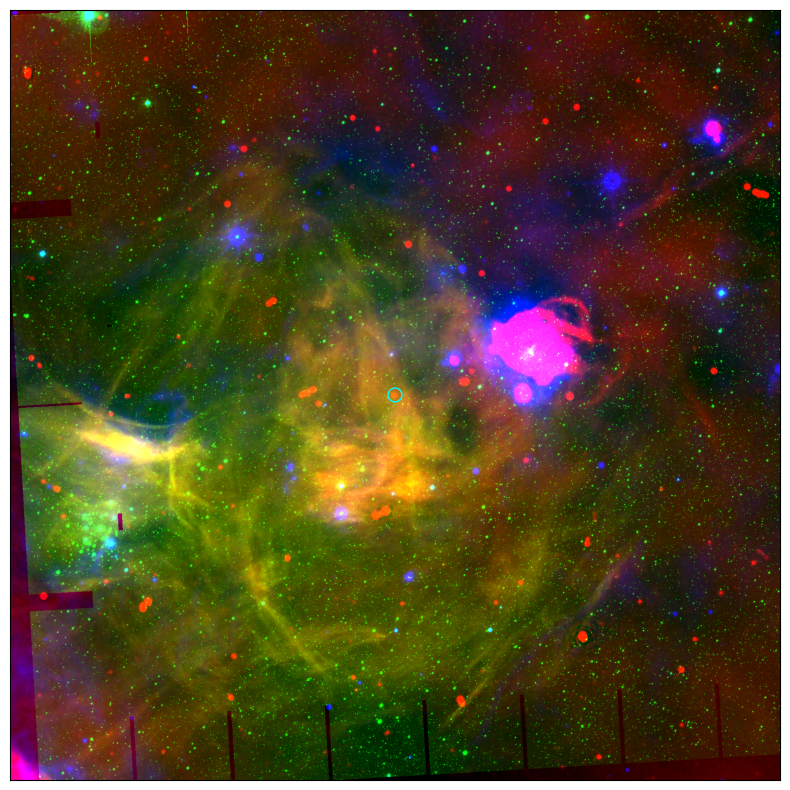

In [168]:
# emu_narr = normalise(emu_array, arr_min=-0.000655962, arr_max=0.00147652)
# wise_narr = normalise(wise_array, arr_min=394, arr_max=909)
# vphas_narr = normalise(vphas_array, arr_min=0, arr_max=120)

emu_narr = normalise(emu_array, arr_min=-0.0007, arr_max=0.002)
wise_narr = normalise(wise_array, arr_min=500, arr_max=1200)
wise_narr[np.isnan(wise_narr)] = np.nanmax(wise_narr)
vphas_narr = normalise(vphas_array, arr_min=10, arr_max=150)

rgb_composite = np.dstack((emu_narr, vphas_narr, wise_narr, ))

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 1, wspace=0.)

ax = plt.subplot(gs[0], projection=wcs)
ax.imshow(rgb_composite, origin="lower")


# source = SkyCoord("10:32:50.44900000", "-58:04:34.57900000", unit=("hour", "deg"))

# ell = Ellipse(
#     (158.2698745, -58.1420344),
#     2 * 0.175 / np.cos(np.radians(-58.1420344)),
#     2 * 0.317,
#     edgecolor="cyan",
#     alpha=0.5,
#     linestyle="--",
#     facecolor="none",
#     transform=ax.get_transform("fk5"),
# )
# ax.add_patch(ell)
# ax.text(
#     157.981,
#     -58.384,
#     "Shell?",
#     color="c",
#     transform=ax.get_transform("fk5"),
# )
# ell2 = Ellipse(
#     (158.2698745, -58.1420344),
#     2 * 0.086 / np.cos(np.radians(-58.1420344)),
#     2 * 0.091,
#     edgecolor="m",
#     facecolor="none",
#     transform=ax.get_transform("fk5"),
# )
# ax.add_patch(ell2)
# ax.text(
#     158.160,
#     -58.247,
#     "PWN?",
#     color="m",
#     transform=ax.get_transform("fk5"),
# )

ax.scatter(
    source.ra, source.dec, 
    marker="o", facecolor="none", edgecolor="cyan", s=100,
    transform=ax.get_transform("fk5")
)

# ax.coords[1].set_axislabel("Declination (J2000)")
# ax.coords[0].set_axislabel("Right Ascension (J2000)")

ax.coords[0].set_ticks_visible(False)
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticks_visible(False)
ax.coords[1].set_ticklabel_visible(False)

# fig.savefig("./RGB_PSRJ1032", bbox_inches="tight")

### Radio Spectra

In [202]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import emcee
import corner
from scipy.optimize import minimize
import matplotlib.ticker as mticker

In [219]:
psr_sed_df = pd.read_csv("../data/PSRJ1032_radio_continuum.csv")

In [221]:
def absorp_model(nu, theta):
    A, alpha, B = theta
    return A * nu ** alpha * np.exp(-B * nu ** -2.1)

def powerlaw_model(nu, theta):
    A, alpha = theta
    return A * nu ** alpha

### define prob, prior functions
def log_prior(theta):
    A, alpha, B = theta # alpha is spectral index here
#     A, alpha = theta
    if A > 0 and B > 0 and alpha < 0:
        return 0.0
    return -np.inf

def log_like(theta, nu, y, yerr):
    model = absorp_model(nu, theta)
#     model = powerlaw_model(nu, theta)
    return -0.5 * np.sum((y - model) ** 2 / yerr ** 2.0)

def log_prob(theta, nu, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp): return -np.inf
    return lp + log_like(theta, nu, y, yerr)

ndim = 3 # three parameters
nwalkers = 64 # 32 chains

np.random.seed(42)
nll = lambda *args: -log_like(*args)
initial = np.array([10, -1.5, 0.5])
initial_sigma = np.array([0.01, 0.01, 0.01]) * np.random.randn(3)

soln = minimize(
    nll, initial+initial_sigma, 
    args=(psr_sed_df["freq"].to_numpy(), psr_sed_df["peak"].to_numpy(), psr_sed_df["peak_err"].to_numpy())
)
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, 
    args=(psr_sed_df["freq"].to_numpy(), psr_sed_df["peak"].to_numpy(), psr_sed_df["peak_err"].to_numpy()),
)
run = sampler.run_mcmc(pos, 1000, progress=True)
flat_samples_gps = sampler.get_chain(flat=True)

You must install the tqdm library to use progress indicators with emcee


In [222]:
def powerlaw_model(nu, theta):
    A, alpha = theta
    return A * nu ** alpha

### define prob, prior functions
def log_prior(theta):
#     A, alpha, B = theta # alpha is spectral index here
    A, alpha = theta
    if A > 0 and alpha < 0:
        return 0.0
    return -np.inf

def log_like(theta, nu, y, yerr):
#     model = absorp_model(nu, theta)
    model = powerlaw_model(nu, theta)
    return -0.5 * np.sum((y - model) ** 2 / yerr ** 2.0)

def log_prob(theta, nu, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp): return -np.inf
    return lp + log_like(theta, nu, y, yerr)

ndim = 2 # three parameters
nwalkers = 64 # 32 chains

np.random.seed(42)
nll = lambda *args: -log_like(*args)
initial = np.array([10, -1.5])
initial_sigma = np.array([0.01, 0.01]) * np.random.randn(ndim)

soln = minimize(
    nll, initial+initial_sigma, 
    args=(psr_sed_df["freq"].to_numpy(), psr_sed_df["peak"].to_numpy(), psr_sed_df["peak_err"].to_numpy())
)
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, 
    args=(psr_sed_df["freq"].to_numpy(), psr_sed_df["peak"].to_numpy(), psr_sed_df["peak_err"].to_numpy()),
)

run = sampler.run_mcmc(pos, 1000, progress=True)

flat_samples_pl = sampler.get_chain(flat=True)

You must install the tqdm library to use progress indicators with emcee


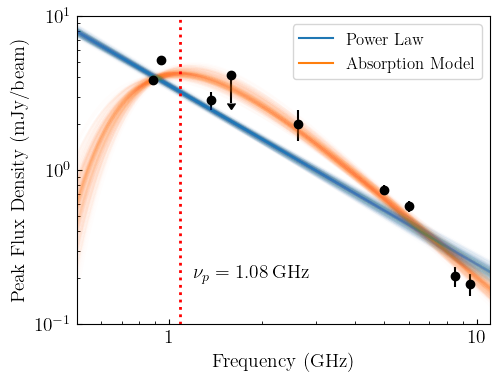

In [223]:
### plot the fitting...
fig = plt.figure(figsize=(4*4/3, 4), facecolor="white")
ax = fig.add_subplot(1, 1, 1)

x0 = np.logspace(-0.3, 1.2, 400)

inds = np.random.randint(len(flat_samples_pl), size=300)
for ind in inds:
    sample = flat_samples_pl[ind]
    ax.plot(x0, powerlaw_model(x0, sample), "C0", alpha=0.01)
    sample = flat_samples_gps[ind]
    ax.plot(x0, absorp_model(x0, sample), "C1", alpha=0.01)
    
ax.errorbar(
    psr_sed_df["freq"], psr_sed_df["peak"], yerr=psr_sed_df["peak_err"],
    ls="none", marker="o", color="black"
)
ax.errorbar(
    1.5881252, 1.37*3, yerr=1.37, uplims=True,
    ls="none", marker="o", color="black",
)

ax.plot([], [], color="C0", label="Power Law")
ax.plot([], [], color="C1", label="Absorption Model")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(0.5, 11)
ax.set_ylim(0.1, 10)

ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Peak Flux Density (mJy/beam)")

ax.axvline(x=1.0858, ls=":", lw=2, color="red")
ax.text(1.2, 0.2, r"$\nu_p=1.08\,$GHz")

ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))

ax.legend(loc="upper right", fontsize=12)

fig.savefig("../figures/PSRJ1032_sed.pdf", bbox_inches="tight")

### Constraints on Absorber

In [214]:
def mask_region(z):
    z = z.astype(int)
    mask = np.zeros_like(z, dtype=bool)
    mask[z == 0] = True
    return np.ma.array(z, mask=mask)

DM = 819 * units.pc * (units.cm) ** -3
B = 0.99 * units.Kelvin ** -1.35 * units.pc * units.cm ** -6

xx = np.linspace(0.1, 0.6, 500) # coefficient for dDM, dDM = xx * DM
yy = np.logspace(-1, 2, 500) # size of the absorber

xx, yy = np.meshgrid(xx, yy)

k = 0.08235
ne = xx * DM.value / yy
Te = ((k * ne**2 * yy) / B.value) ** (1/1.35)

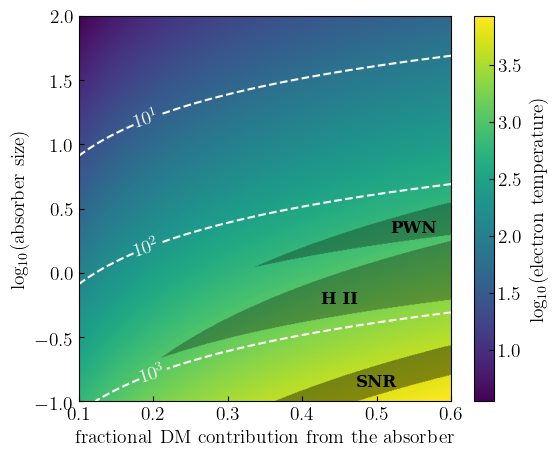

In [302]:
fig = plt.figure(figsize=(6, 5), facecolor="white")
ax = fig.add_subplot(1, 1, 1)

im = ax.imshow(
    np.log10(Te), aspect="auto", origin="lower", extent=(0.1, 0.6, -1, 2), 
)
xx = np.linspace(0.1, 0.61, 500)

cs = ax.contour(
    ne, extent=(0.1, 0.6, -1, 2), levels=[10, 100, 1000],
    colors="white", linestyles="dashed"
)
manual_locs = [
    (0.2, 1.0), (0.2, 0.0), (0.2, -0.8)
]
fmt = matplotlib.ticker.LogFormatterSciNotation()
fmt.create_dummy_axis()
ax.clabel(cs, inline=True, manual=manual_locs, fmt=fmt)

    
### plot SNR possible region
snrreg = (ne > 1e3) & (Te > 4e3) & (Te < 6e3)
snrreg = mask_region(snrreg)
ax.contourf(
    snrreg, extent=(0.1, 0.6, -1, 2), 
    colors="black", alpha=0.4,
    antialiased=True
)
ax.text(
    0.5, -0.85, "SNR", ha="center", va="center", color="black", 
    fontsize=12, weight="bold", usetex=False,
)

pwnreg = (ne > 50) & (ne < 250) & (Te > 600) & (Te < 2400)
pwnreg = mask_region(pwnreg)
ax.contourf(
    pwnreg, extent=(0.1, 0.6, -1, 2), 
    colors="black", alpha=0.3,
    antialiased=True
)
ax.text(
    0.55, 0.35, "PWN", ha="center", va="center", color="black", 
    fontsize=12, weight="bold", usetex=False,
)

hiireg = (ne > 100) & (ne < 800) & (Te > 1000) & (Te < 5000)
hiireg = mask_region(hiireg)
ax.contourf(
    hiireg, extent=(0.1, 0.6, -1, 2), 
    colors="black", alpha=0.3,
    antialiased=True
)
ax.text(
    0.45, -0.20, "H II", ha="center", va="center", color="black", 
    fontsize=12, weight="bold", usetex=False,
)

cb = plt.colorbar(im)
cb.set_label(r"log$_{10}$(electron temperature)")
    
ax.set_xlim(0.1, 0.6)
ax.set_ylim(-1, 2)

ax.set_xlabel("fractional DM contribution from the absorber")
ax.set_ylabel(r"log$_{10}$(absorber size)")

fig.savefig("../figures/PSRJ1032_absorber_prop.pdf", bbox_inches="tight")

### Pulsar Period-DM plot

In [226]:
from astropy import units as u, constants as c
from astropy.table import Table
from astropy.io import ascii
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors

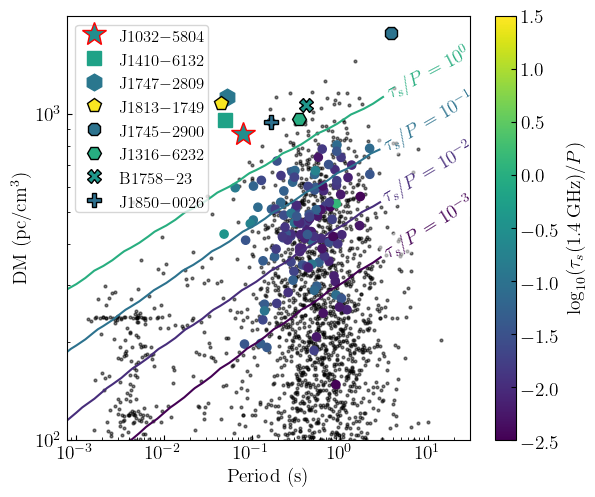

In [298]:
data = ascii.read("../data/psrs.csv", delimiter=";", fill_values=(("*", -99)))

fig = plt.figure(figsize=(6.5, 5.5))

plt.loglog(data["P0"], data["DM"], "k.", alpha=0.5, markersize=4, zorder=0)

p = np.logspace(-3.5, 1.5)
dm = np.logspace(0.3, 3.3, 51)
nu = 1.4
P, DM = np.meshgrid(p, dm)
# Bhat et al. (2004)
a = -6.46
b = 0.154
c = 1.07
alpha = 3.5
tau = 10 ** (a + b * np.log10(DM) + c * np.log10(DM) ** 2 - alpha * np.log10(nu)) * u.ms
# catalog values are 1 GHz.  Convert to 1.4
tau_meas = data["TAU_SC"] * u.s * (1 / nu) ** alpha
tau_meas[tau_meas < 0] = 0


norm = matplotlib.colors.LogNorm(vmin=10**-2.5, vmax=10**1.5)
cm = plt.cm.viridis
sc = plt.scatter(
    data["P0"][tau_meas > 0],
    data["DM"][tau_meas > 0],
    c=np.log10(tau_meas.value[tau_meas > 0] / data["P0"][tau_meas > 0]),
    vmin=-2.5,
    vmax=1.5,
    s=35,
)
cbar = plt.colorbar(sc)
cbar.set_label("$\log_{10}(\\tau_s(1.4\\,{\\rm GHz})/P)$") #, fontsize=14)

cs = plt.contour(
    p, dm, (tau.to_value(u.s) / p), 10 ** np.arange(-3.0, 1.0), cmap=cm, norm=norm
)

textlist = data[(tau_meas > 0) & (data["DM"] > 900)]
# for i in range(len(textlist)):
#     if textlist[i]["NAME"].startswith("J1745-2900"):
#         plt.text(textlist[i]["P0"], textlist[i]["DM"], textlist[i]["NAME"], ha="right")

plt.loglog(
    0.0787,
    868,
    "*",
    markersize=18,
    label="J1032$-$5804",
    color=cm(norm(15e-3 / (nu / 3.26) ** alpha)),
    markeredgecolor="r",
)
# plt.text(0.0787, 868 * 1.2, "PSR J1032$-$5804")
# https://ui.adsabs.harvard.edu/abs/2008MNRAS.388L...1O/abstract
# estimate scattering timescale from their Figure 3
plt.loglog(
    0.050, 961, "s", markersize=10, label="J1410$-$6132", color=cm(norm((32 / 50)))
)
# https://ui.adsabs.harvard.edu/abs/2009ApJ...700L..34C/abstract
plt.loglog(
    0.0522,
    1133,
    "h",
    markersize=12,
    label="J1747$-$2809",
    color=cm(norm((21 * (1 / nu) ** alpha / 52.2))),
)
# https://ui.adsabs.harvard.edu/abs/2021ApJ...917...67C/abstract
names = ["J1813-1749", "J1745-2900", "J1316-6232", "B1758-23", "J1850-0026"]
symbols = ["p", "8", "H", "X", "P"]
sizes = [10, 10, 10, 10, 10]
for n, sy, si in zip(names, symbols, sizes):
    sel = data["NAME"] == n
    plt.loglog(
        data[sel]["P0"],
        data[sel]["DM"],
        sy,
        markersize=si,
        label=n.replace("-", "$-$"),
        color=cm(norm((tau_meas[sel].value / data[sel]["P0"])[0])),
        markeredgecolor="k",
    )
plt.xlabel("Period (s)") #, fontsize=14)
plt.ylabel("DM (pc/cm$^3$)") #, fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.axis([0.8e-3, 30, 100, 2000])
pplot = 10
tau = 10 ** (a + b * np.log10(dm) + c * np.log10(dm) ** 2 - alpha * np.log10(nu)) * u.ms
dmplot = np.interp([-3, -2, -1, 0], np.log10(tau.to_value(u.s) / pplot), dm)

clabels = plt.gca().clabel(
    cs,
    fmt=lambda x: "$\\tau_s/P=10^{{{:d}}}$".format(int(np.round(np.log10(x)))),
    manual=list(zip([pplot] * len(dmplot), dmplot)),
)
[
    txt.set_bbox(dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2))
    for txt in clabels
]

plt.legend(
    loc="upper left", fontsize=12, ncol=1,
    borderpad=0.15, labelspacing=0.4, handletextpad=0.5
)

fig.savefig("../figures/PSRJ1032_P_DM.pdf", bbox_inches="tight")